In [5]:

import os
import numpy as np
import matplotlib.pyplot as plt
split = "test"
dest_path = "/liuzicheng/ljh/hyena-dna/data/splicing_prediction"
all_seqs = np.load(os.path.join(dest_path,  split + "_seq.npy"), allow_pickle=True)
all_labels = np.load(os.path.join(dest_path,  split + "_target.npy"), allow_pickle=True)


In [6]:
hyena_path='/liuzicheng/ljh/hyena-dna/outputs/2024-04-03/15-12-52-724312/checkpoints/val/pr_auc_mean.ckpt'
mamba_path='/liuzicheng/ljh/hyena-dna/outputs/2024-04-20/02-29-01-651292/checkpoints/val/pr_auc_mean.ckpt'
NT_path='/liuzicheng/ljh/hyena-dna/outputs/2024-04-08/01-41-26-952782/checkpoints/val/pr_auc_mean.ckpt'
genalm_path='/liuzicheng/ljh/hyena-dna/outputs/2024-04-06/11-21-47-532494/checkpoints/val/pr_auc_mean.ckpt'
bert2_path='/liuzicheng/ljh/hyena-dna/outputs/2024-04-02/18-41-34-140615/checkpoints/val/pr_auc_mean.ckpt'
batch_size=1
max_length=3000

import torch
from sklearn.metrics import f1_score, roc_auc_score
def pr_auc(logits,y):
    # compute metrics based on stored labels, predictions, ...
    metrics = {}
    y, p = y, torch.sigmoid(logits)
    #convert three dimension into 2 dimension
    y=y.reshape(-1,y.shape[-1]).cpu().numpy()
    p=p.reshape(-1,p.shape[-1]).cpu().detach().numpy()
    # compute pr-auc for each class independetly
    for label in [0, 1, 2]:
        y_label = y[:, label]
        p_label = p[:, label]
        if not np.isnan(p_label).any():
            try:
                pr_auc = roc_auc_score(y_label, p_label)
            except ValueError:
                #calculate accurate rate for this label
                #convert p_label to 0-1
                p_label = (p_label > 0.5).astype(int)
                accurate_rate = (y_label == p_label).sum() / len(y_label)
                #if accurate rate is 1, set pr_auc to 1
                pr_auc = accurate_rate
        else:
            pr_auc = np.nan
        # to be compatible with sklearn 1.1+
        metrics[f'pr_auc_{label}'] = pr_auc if not np.isnan(pr_auc) else 0.0
    metrics['pr_auc_mean'] = (metrics['pr_auc_1'] + metrics['pr_auc_2']) / 2
    return metrics

def f1_micro(logits, y):
    logits = logits.view(-1, logits.shape[-1])
    y = y.view(-1)
    y_hat = torch.argmax(logits, dim=-1)
    return f1_score(y.cpu().numpy(), y_hat.cpu().numpy(), average="micro")

/tmp/ipykernel_8534/2253030854.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence_tensor=torch.tensor(seqs).to('cuda')
/tmp/ipykernel_8534/2253030854.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor=torch.tensor(targets).to('cuda')


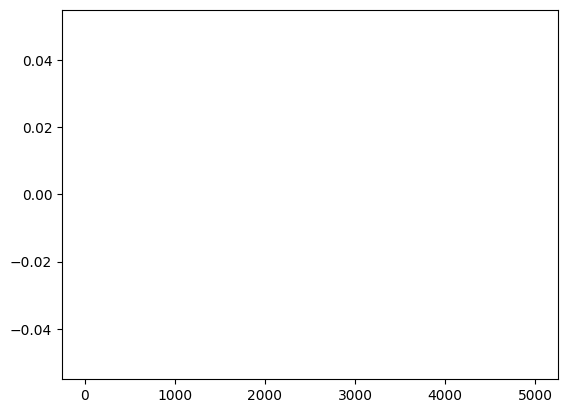

In [32]:
#import autotokenizer
from transformers import AutoTokenizer,AutoModel
import torch
from torch import nn
x_axs=[]
for i in range(5000):
    x_axs.append(i)
with torch.no_grad():
    hyena_tokenizer=AutoTokenizer.from_pretrained("/liuzicheng/ljh/hyena-dna/weight/hyenadna/hyenadna-large-1m-seqlen",trust_remote_code=True)
    hyena_model=AutoModel.from_pretrained("/liuzicheng/ljh/hyena-dna/weight/hyenadna/hyenadna-large-1m-seqlen",trust_remote_code=True).to('cuda')
    full_sequence=[]
    checkpoint=torch.load(hyena_path)['state_dict']
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model.backbone."
        )
    torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0.length_transform_2."
        )

    hyena_decoder = nn.Linear(256,3,bias=False).to('cuda')
    #edit key name in hyena_decoder
    state_dict=hyena_decoder.state_dict()
    
    hyena_model.load_state_dict(checkpoint,strict=False)
    hyena_decoder.load_state_dict(checkpoint,strict=False)
    hyena_model.eval()
    hyena_decoder.eval()

    seqs=[]
    targets=[]
    for i in range(batch_size):
        sequence_encoded=hyena_tokenizer(all_seqs[2],
                            add_special_tokens= False,  # this is what controls adding eos
                            padding="max_length",
                            max_length=max_length,
                            truncation=True,
                        )
        seq_ids=sequence_encoded['input_ids']
        seq_ids = torch.LongTensor(seq_ids)
        target = all_labels[6][:5000,:]
        target = torch.LongTensor(target)
        seqs.append(seq_ids)
        targets.append(target)
        
    seqs=torch.stack(seqs)

    targets=torch.stack(targets)
    sequence_tensor=torch.tensor(seqs).to('cuda')
    target_tensor=torch.tensor(targets).to('cuda')

    hidden_states=hyena_model(sequence_tensor)['last_hidden_state']
    output=hidden_states[..., :1000, :]
    out1=hyena_decoder(output)


    #calculate the 
    # auc_roc=pr_auc(targets,out1)
    # print(auc_roc)
    #plot the
    position=targets.argmax(dim=-1)
    plt.bar(x_axs,position[0])
